# Data Wrangling

Some data needs to be downloaded manually yourself before you can run the commands below.

## LitPop's population count data

Gridded Population of the World (GPW), v4: Population Count, v4.10, v4.11 or later versions (2000, 2005, 2010, 2015, 2020), available from http://sedac.ciesin.columbia.edu/data/collection/gpw-v4/sets/browse.

The GPW file of the year closest to the requested year (reference_year) is required. To download GPW data a (free) login for the NASA SEDAC website is required.

Direct download links are avilable, also for older versions, i.e.:

    v4.11: http://sedac.ciesin.columbia.edu/downloads/data/gpw-v4/gpw-v4-population-count-rev11/gpw-v4-population-count-rev11_2015_30_sec_tif.zip
    v4.10: http://sedac.ciesin.columbia.edu/downloads/data/gpw-v4/gpw-v4-population-count-rev10/gpw-v4-population-count-rev10_2015_30_sec_tif.zip,
    Overview over all versions of GPW v.4: https://beta.sedac.ciesin.columbia.edu/data/collection/gpw-v4/sets/browse

The population data from GWP needs to be downloaded manually as TIFF from this site and placed in the SYSTEM_DIR folder of your climada installation.

## ISIMIP flood data

Instructions for the river flood calculation are in [this tutorial](https://climada-petals.readthedocs.io/en/stable/tutorial/climada_hazard_RiverFlood.html). As of this writing, the [ISIMIP data](https://files.isimip.org/cama-flood/) needed to be manually downloaded from https://data.isimip.org/search/query/10.48364/ISIMIP.303619/

We want to download ISIMIP2a (1971-2010) and ISIMIP2b (2006-2100) data. This can be done by separately selecting ISIMIP2a and Derived Output data, and then in the first data set listed, you can select "Download all files." Repeat for ISIMIP2B. These files are *.nc4 files. Put them in the climada data folder.


## Historical landslide data

For landslide data, you need to download the data from Cooperative Open Online Landslide Repository (https://pmm.nasa.gov/landslides/coolrdata.html#download)

The most recent version of the dataset should always be downloaded by going to the link > “Open Landslide Viewer” (takes some time to load) > click “Download the full Landslide Catalog” > selecting the “NASA Global Landslide Catalog Points (Shapefile)” for download.

Unzip and extract into the /climada folder in your home directory (not the climada-python or climada-petals code repositories).

Important: The original file has a typo in one of its entries, which messes up the reading of a bounding box. Reading it once into memory with geopandas and re-saving it as shapefile solves this. This has to be done only once.

# Computation

An impact calculation combines a given Hazard with Exposure and Impact functions to output an Impact. The Impact class can be used to output data as needed. The calculation uses the nearest neighbor Exposure for a given Hazard Centroid. It's recommended to set the spatial resolution by the initialization of the Exposure, and then matching the centroids to the grid in Exposure, for a 1 to 1 calculation.

Exposure is independent of hazard, but the impact functions are for associated hazards. If you want to output a certain impact, say of cyclones, floods, drought, you need to create the Hazard class, specify the hazard data, and attach meaningful impact functions for that hazard.

The exposures, hazards and impact functions must be matched in the impact calculations. In the case where there is a single impact function for all the hazards, we must simply make sure that the exposure is assigned this impact function through renaming the impf\_ column from the hazard type of the impact function in the impact function set, and set the values of the column to the id of the impact function.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from climada.entity import LitPop

from climada.entity.entity_def import Entity
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
from climada.engine import ImpactCalc
from climada import CONFIG

/home/ming/mambaforge/envs/climada_env/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


## Exposure

Set up exposure using LitPop. Default parameters are resolution of 30 arcsec, produced capital ('pc') as total asset value, and exponents of (lit, pop) as (1,1). These can be changed when calling `LitPop`.
For NZ, seems there is no pc data, and 'non-financial wealth' was by default used as total asset value. 

In [3]:
# NZ with resolution 10km
exp_nz = LitPop.from_countries(countries=['NZL'], res_arcsec=300)
exp_nz.check()

2024-07-13 22:17:49,198 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-13 22:17:49,224 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-13 22:17:49,242 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-13 22:17:49,258 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-13 22:17:49,295 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-13 22:17:49,313 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2024-07-13 22:17:49,332 - climada.entity.exposures.litpop.gpw_populati

/home/ming/mambaforge/envs/climada_env/lib/python3.9/site-packages/climada/util/coordinates.py:2492: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_poly['geometry'] = apply_box(points_df)



 Raster properties exposures: {'width': 4268, 'height': 218, 'crs': <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, 'transform': Affine(0.08333332999998788, 0.0, -176.83333333500002,
       0.0, -0.08333333000000209, -34.416666665)}


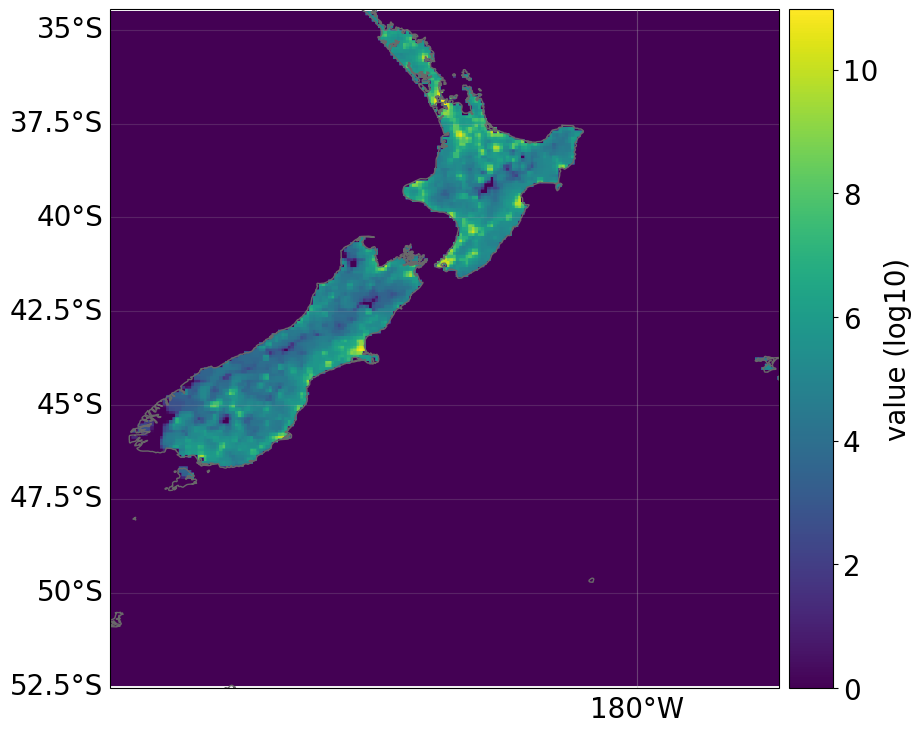

In [4]:
# not needed for impact calculations
# visualize the define exposure
exp_nz.plot_raster()
print('\n Raster properties exposures:', exp_nz.meta)

## Hazard

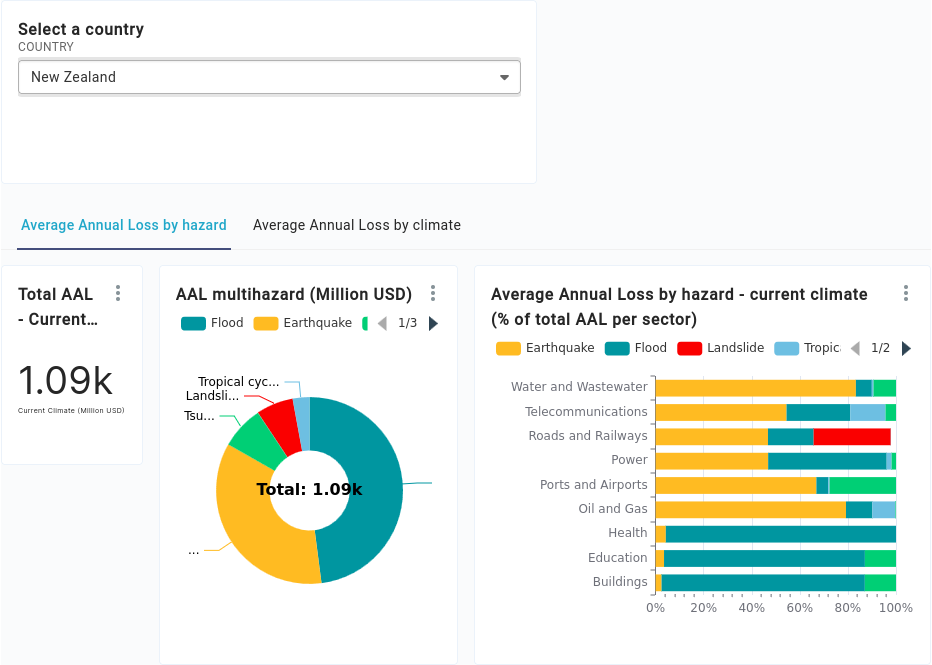

The hazards most relevant to New Zealand, according to the UNEP GRID GIRI data portal, are floods and earthquake, followed by tsunami, landslides (rain and earthquake triggered) and cyclones (wind and surge).

The hazards offered by CLIMADA are river floods, landslides, tropical cyclones, and wildfires.

River floods are calculated using recent ISIMIP2a (1971-2010) and ISIMIP2b (2005-2100) data.

Landslides can be calculated from historical data from COOLR data, or probabilistic hazardsets from UNEP GRID PREVIEW project. The COOLR data is accessible, but **the PREVIEW data no longer is available publicly**, since the website is no longer up, and the direct links offered in the tutorial are no longer valid. **Can ask CLIMADA team for data?**

Tropical cyclones can be calculated from storm tracks from IBTRaCS. This looks at wind impacts. There are further refinements, such as looking at rain fall from cyclones, and surge.

### River Flood

In [5]:
from climada_petals.hazard.river_flood import RiverFlood
from climada_petals.util.constants import RIVER_FLOOD_REGIONS_CSV

PATH_FLDDPH = '/home/ming/climada/data/cama-flood_clm40_gswp3_nobc_hist_nosoc_co2_flddph_none_150arcsec_global_annual_1971_2010.nc4'
PATH_FLDFRC = '/home/ming/climada/data/cama-flood_clm40_gswp3_nobc_hist_nosoc_co2_fldfrc_none_150arcsec_global_annual_1971_2010.nc4'

/home/ming/mambaforge/envs/climada_env/lib/python3.9/site-packages/climada/util/coordinates.py:896: RuntimeWarning: invalid value encountered in cast
  region_id = hdf5_f['NatIdGrid'].reshape(grid_shape).astype(int)


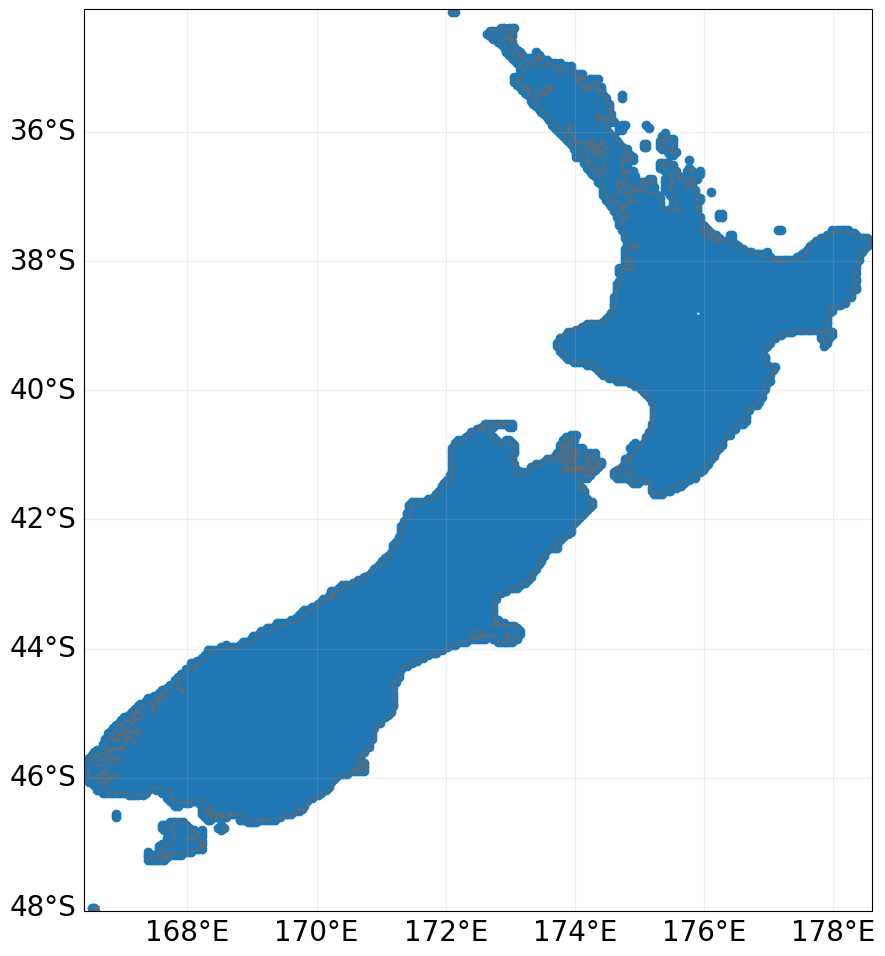

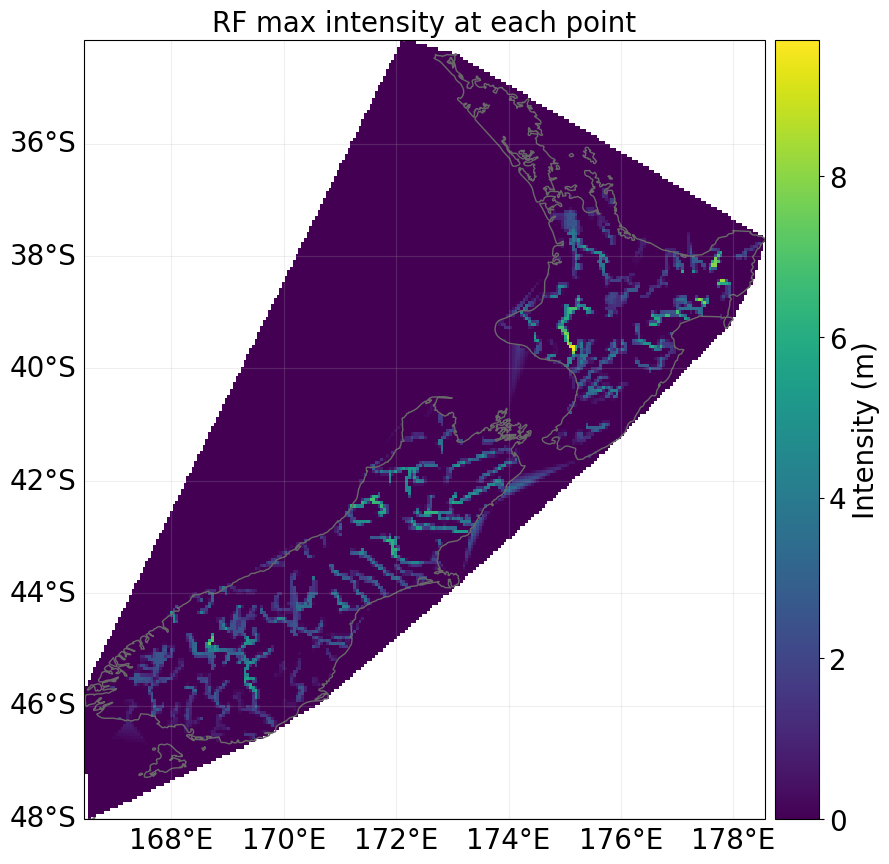

In [6]:
years = [2000]
# generating RiverFlood hazard from netCDF file
# uses centroids from Natural Earth Multipolygon for NZ
haz_rf = RiverFlood.from_nc(
    countries = ['NZL'], 
    years=years, 
    dph_path=PATH_FLDDPH, 
    frc_path=PATH_FLDFRC, ISINatIDGrid=True)
haz_rf.centroids.plot()
haz_rf.plot_intensity(event=0, smooth = False);

/home/ming/mambaforge/envs/climada_env/lib/python3.9/site-packages/climada/hazard/centroids/centr.py:873: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy_pixels = self.geometry.buffer(res / 2).envelope


Total flooded area for year 2000 in NZ:
8576725754.089946 m2
Total flooded area at first event in NZ:
8576725754.089946 m2


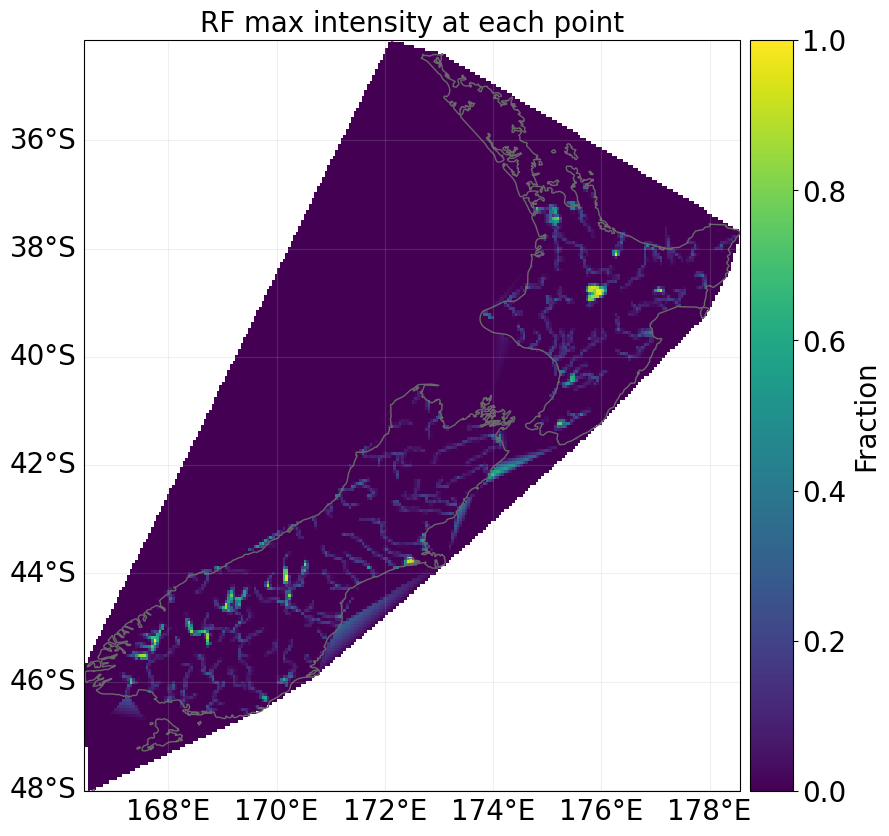

In [7]:
#setting river flood
haz_rf.plot_fraction(event=0, smooth = False)
# calculating flooded area
haz_rf.set_flooded_area()
print("Total flooded area for year " + str(years[0]) + " in NZ:")
print(str(haz_rf.fla_annual[0]) + " m2")

print("Total flooded area at first event in NZ:")
print(str(haz_rf.fla_event[0]) + " m2");

In [8]:
#calculate flooded area
haz_rf.set_flooded_area(save_centr = True)
print("affected area in each affected centroid and each event:")
haz_rf.fla_ev_centr.data

/home/ming/mambaforge/envs/climada_env/lib/python3.9/site-packages/climada/hazard/centroids/centr.py:873: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xy_pixels = self.geometry.buffer(res / 2).envelope


affected area in each affected centroid and each event:


array([  672097.15013939,   310633.13430465,  1580300.6971382 , ...,
       12893420.57159048,   134870.27758072,   298439.61635765])

<Axes: title={'center': 'RF 5: Flood Oceania JRC Residential noPAA'}, xlabel='Intensity (m)', ylabel='Impact (%)'>

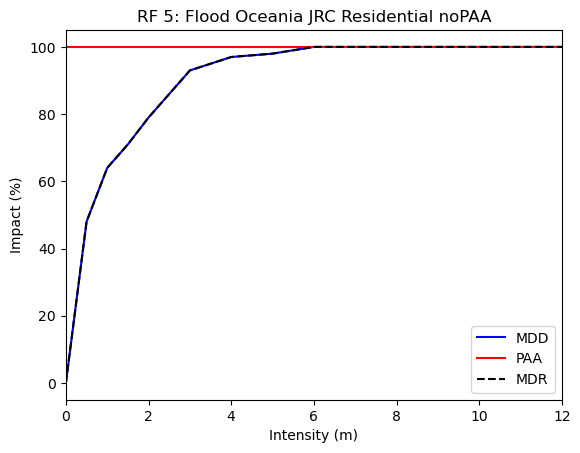

In [12]:
# import impact function set for RiverFlood using JRC damage functions () for 6 regions
from climada_petals.entity.impact_funcs.river_flood import ImpfRiverFlood, flood_imp_func_set
impf_set = flood_imp_func_set()
impf_oceania = impf_set.get_func(fun_id=5)
impf_oceania[0].plot()

2024-07-13 22:19:56,315 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2024-07-13 22:19:56,340 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 26 coordinates.


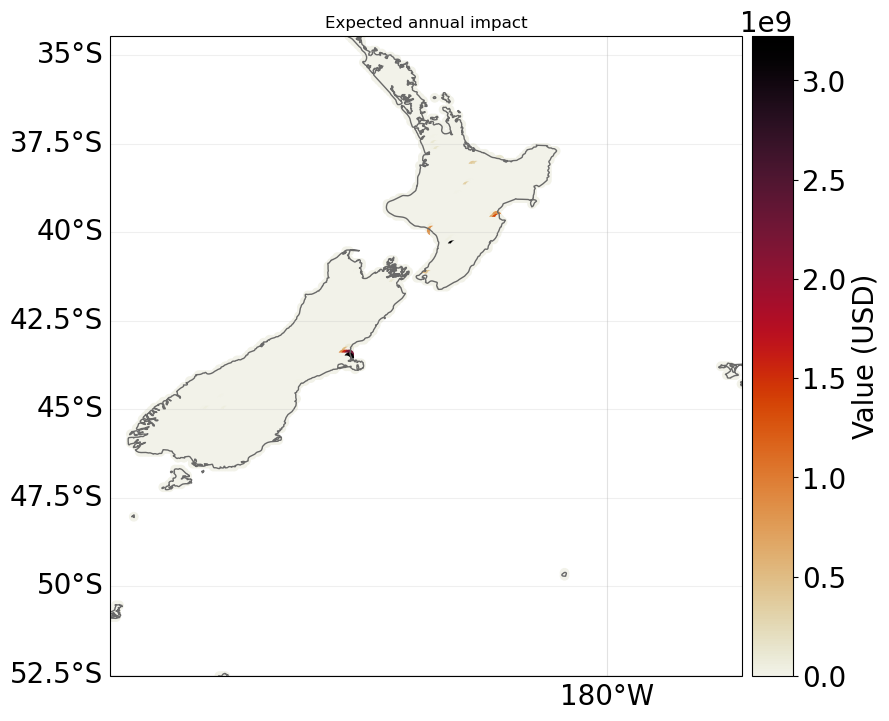

In [13]:
# In the LitPop exposure the damage function for river floods needs
# to be specified manually.
info = pd.read_csv(RIVER_FLOOD_REGIONS_CSV)
exp_nz.gdf['impf_RF'] = info.loc[info['ISO']=='NZL','impf_RF'].values[0]

imp_rf=Impact()
imp_rf.calc(exp_nz, impf_set, haz_rf, save_mat=True)
imp_rf.plot_scatter_eai_exposure();

### Landslides

In [14]:
from climada_petals.hazard.landslide import Landslide
# replace with your path to file nasa_global_landslide_catalog_point.shp if not in ~/climada/data folder
PATH_COOLR = str(CONFIG.local_data.system.dir()) + '/nasa_global_landslide_catalog_point/nasa_global_landslide_catalog_point.shp'

2024-07-13 22:20:14,651 - climada.util.coordinates - WARNING - This function has been renamed, use match_grid_points instead.


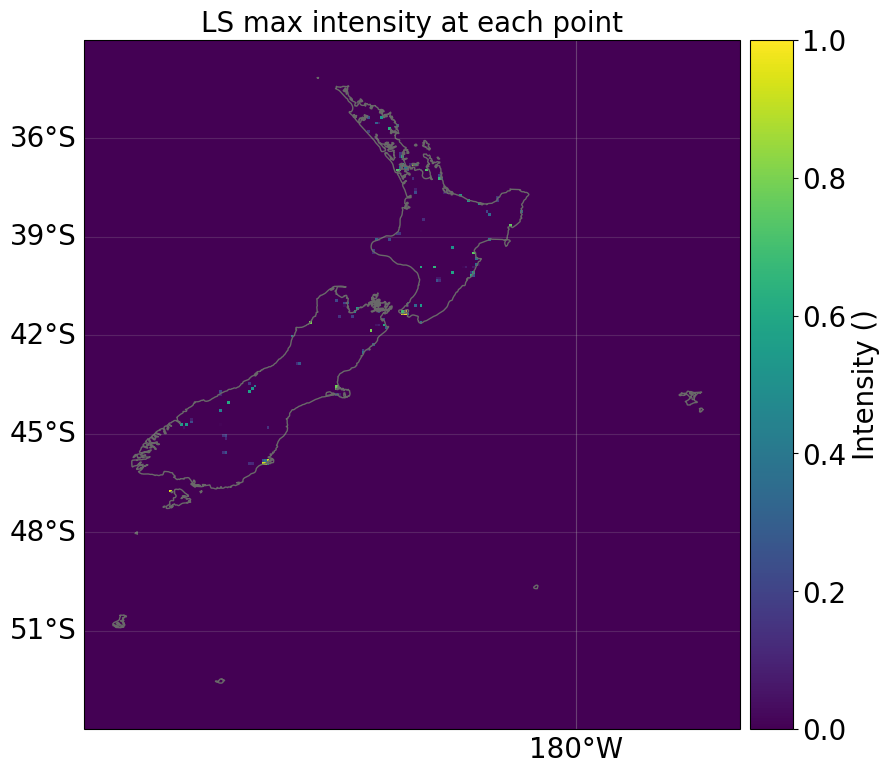

In [15]:
bbox_nz = (165.0, -54.0, 185.0, -33.0) # bbox as (minx, miny, maxx, maxy)
# Example for NZ
haz_ls_NZ_hist = Landslide.from_hist(bbox=bbox_nz, input_gdf=PATH_COOLR, res=0.05)
# Visual inspection of the hazard
haz_ls_NZ_hist.plot_intensity(0);

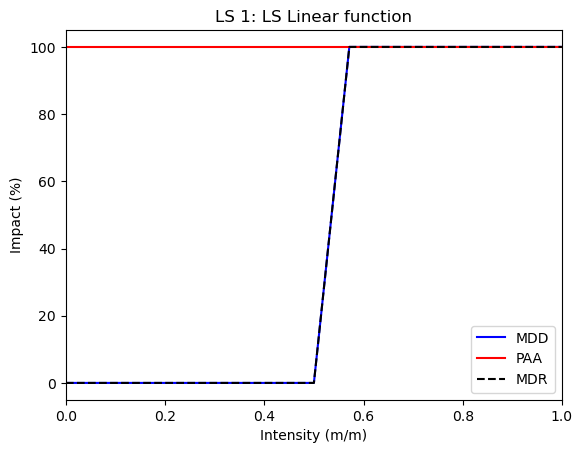

In [16]:
# Set impact function (see tutorial climada_entity_ImpactFuncSet)
impf_LS_hist = ImpactFunc()
impf_LS_hist.haz_type = 'LS'
impf_LS_hist.id = 1
impf_LS_hist.name = 'LS Linear function'
impf_LS_hist.intensity_unit = 'm/m'
impf_LS_hist.intensity = np.linspace(0, 1, num=15)
impf_LS_hist.mdd = np.sort(np.array([0,0,0,0,0,0,0,0,1., 1., 1., 1., 1., 1., 1.]))
impf_LS_hist.paa = np.sort(np.linspace(1, 1, num=15))
impf_LS_hist.check()
impf_LS_hist.plot()
ifset_LS_hist = ImpactFuncSet()
ifset_LS_hist.append(impf_LS_hist)

In [17]:
# Set impact functions to
exp_nz.set_geometry_points()
exp_nz.gdf.rename({'impf_': 'impf_LS'}, axis='columns',inplace=True)
exp_nz.set_lat_lon()
exp_nz.check()

In [18]:
# Set Entity
ent_LS_hist = Entity()
ent_LS_hist.exposures = exp_nz
ent_LS_hist.impact_funcs = ifset_LS_hist

2024-07-13 22:20:43,381 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


/home/ming/mambaforge/envs/climada_env/lib/python3.9/site-packages/climada/util/coordinates.py:2749: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(
/home/ming/mambaforge/envs/climada_env/lib/python3.9/site-packages/climada/util/coordinates.py:2492: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geomet

The overall estimated impact from all events is 3075195121 $


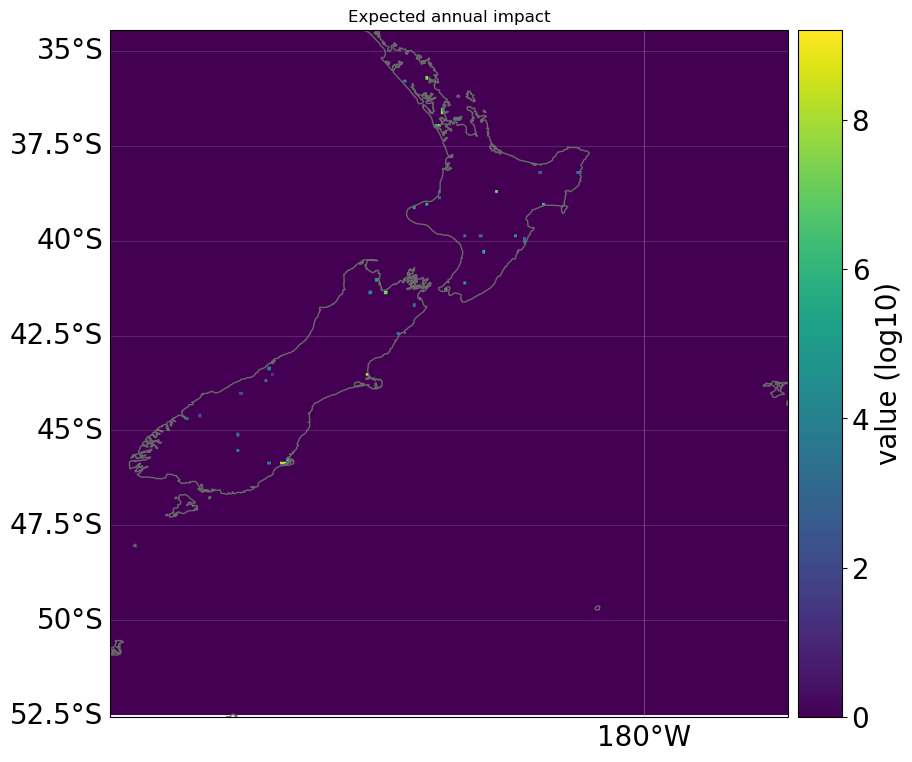

In [19]:
# Impact calculation from historic landslides, with exposure and impact function defined as above.
imp_LS_NZ_hist = Impact()
imp_LS_NZ_hist.calc(
    ent_LS_hist.exposures, ent_LS_hist.impact_funcs, 
    haz_ls_NZ_hist)
imp_LS_NZ_hist.plot_raster_eai_exposure()
print(f'The overall estimated impact from all events is {int(imp_LS_NZ_hist.aai_agg)} $');


### Cyclones

In [24]:
from climada.hazard import TCTracks, TropCyclone, Centroids
from climada.entity import ImpfTropCyclone

# Load histrocial tropical cyclone tracks from ibtracs over the North Atlantic basin between 2010-2012
ibtracks_nz = TCTracks.from_ibtracs_netcdf(provider='wellington', basin='SP', year_range=(2010, 2012), correct_pres=True)
print('num tracks hist:', ibtracks_nz.size)

ibtracks_nz.equal_timestep(0.5)  # Interpolation to make the track smooth and to allow applying calc_perturbed_trajectories
# Add randomly generated tracks using the calc_perturbed_trajectories method (1 per historical track)
ibtracks_nz.calc_perturbed_trajectories(nb_synth_tracks=1)
print('num tracks hist+syn:', ibtracks_nz.size)

2024-07-13 22:22:39,210 - climada.hazard.tc_tracks - WARNING - `correct_pres` is deprecated. Use `estimate_missing` instead.
2024-07-13 22:22:39,402 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ming/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-07-13 22:22:40,239 - climada.hazard.tc_tracks - WARNING - 13 storm events are discarded because no valid wind/pressure values have been found: 2010020S14147, 2010022S12160, 2010027S14184, 2010038S08194, 2010051S06195, ...
num tracks hist: 15
num tracks hist+syn: 30


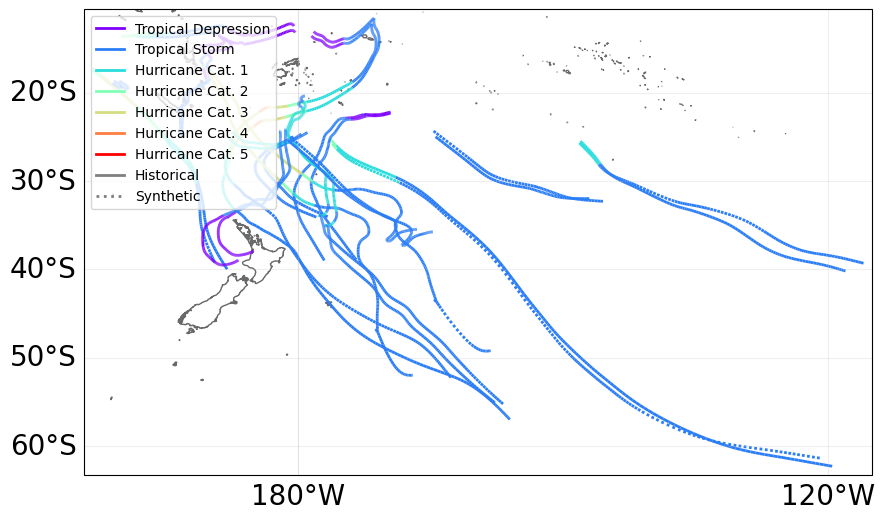

In [21]:
# not needed for calculations
# visualize tracks
ax = ibtracks_nz.plot()
ax.get_legend()._loc = 2

In [25]:
# Define the centroids from the exposures position
lat = exp_nz.gdf['latitude'].values
lon = exp_nz.gdf['longitude'].values
centrs = Centroids.from_lat_lon(lat, lon)
centrs.check()

In [26]:
# Using the tracks, compute the windspeed at the location of the centroids
haz_tc = TropCyclone.from_tracks(ibtracks_nz, centroids=centrs)
haz_tc.check()

In [27]:
# impact function TC
impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet([impf_tc])
impf_set.check()

In [28]:
# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

hazard type: TC, hazard id: 1


In [29]:
# Exposures: rename column and assign id
exp_nz.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
exp_nz.gdf['impf_' + haz_type] = haz_id
exp_nz.check()
exp_nz.gdf.head()

,value,latitude,longitude,geometry,region_id,impf_LS,impf_RF,centr_RF,centr_LS,impf_TC
0,0.0,-50.875000,165.958333,POINT (165.95833 -50.87500),554,1,5,-1,143577,1
1,0.0,-50.875000,166.041667,POINT (166.04167 -50.87500),554,1,5,-1,143579,1
2,0.0,-50.875000,166.125000,POINT (166.12500 -50.87500),554,1,5,-1,143580,1
3,0.0,-50.541667,166.125000,POINT (166.12500 -50.54167),554,1,5,-1,140773,1
4,0.0,-50.541667,166.208333,POINT (166.20833 -50.54167),554,1,5,-1,140775,1


In [30]:
# Compute impact
imp_tc = ImpactCalc(exp_nz, impf_set, haz_tc).impact(save_mat=False)  # Do not save the results geographically resolved (only aggregate values)

In [31]:
exp_nz.gdf

,value,latitude,longitude,geometry,region_id,impf_LS,impf_RF,centr_RF,centr_LS,impf_TC,centr_TC
0,0.000000e+00,-50.875000,165.958333,POINT (165.95833 -50.87500),554,1,5,-1,143577,1,0
1,0.000000e+00,-50.875000,166.041667,POINT (166.04167 -50.87500),554,1,5,-1,143579,1,1
2,0.000000e+00,-50.875000,166.125000,POINT (166.12500 -50.87500),554,1,5,-1,143580,1,2
3,0.000000e+00,-50.541667,166.125000,POINT (166.12500 -50.54167),554,1,5,-1,140773,1,3
4,0.000000e+00,-50.541667,166.208333,POINT (166.20833 -50.54167),554,1,5,-1,140775,1,4
...,...,...,...,...,...,...,...,...,...,...,...
4194,3.537527e+06,-36.791667,175.125000,POINT (175.12500 -36.79167),554,1,5,16809,30678,1,4194
4195,2.371736e+05,-36.208333,175.375000,POINT (175.37500 -36.20833),554,1,5,17135,25872,1,4195
4196,5.130039e+05,-36.208333,175.458333,POINT (175.45833 -36.20833),554,1,5,17137,25873,1,4196
4197,5.367681e+05,-36.291667,175.541667,POINT (175.54167 -36.29167),554,1,5,17060,26677,1,4197


In [32]:
print(f"Aggregated average annual impact: {round(imp_tc.aai_agg,0)} $")

Aggregated average annual impact: 0.0 $


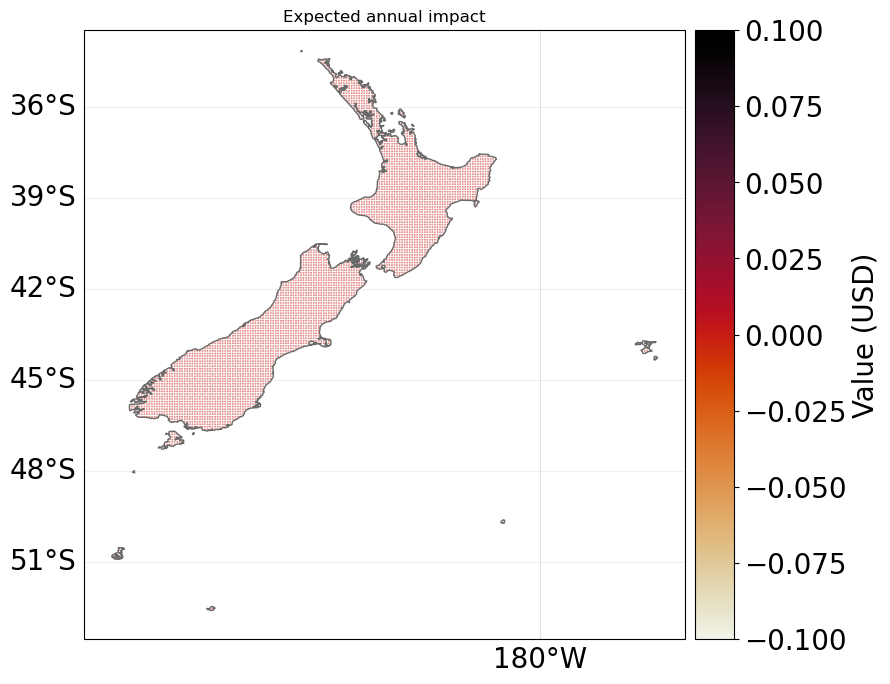

In [33]:
imp_tc.plot_hexbin_eai_exposure(buffer=1);

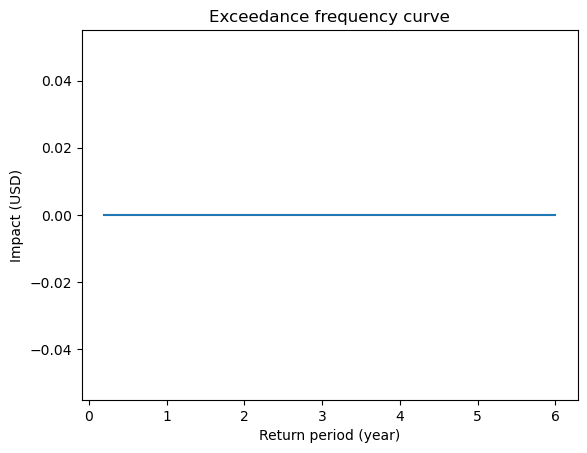

In [35]:
# Compute exceedance frequency curve
freq_curve = imp_tc.calc_freq_curve()
freq_curve.plot();

<GeoAxes: title={'center': 'Expected annual impact'}>

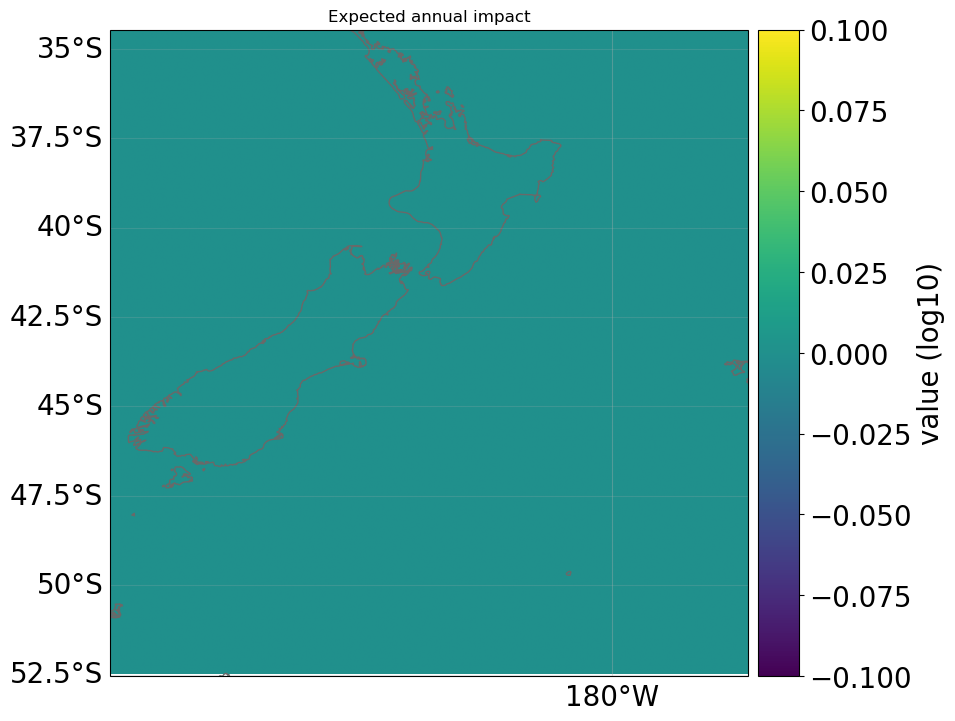

In [34]:
imp_tc.plot_raster_eai_exposure()